### Aplicação do Método Analítico

## Importação de bibliotecas

In [1]:
# O módulo pmdarima.arima é incompatível com a versão mais recente do NumPy
# Por isso instalaremos a versão 1.23.5
!pip install numpy==1.23.5
!pip install pmdarima
!pip install sktime
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
import math
from pylab import rcParams
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.base import ForecastingHorizon


  Using cached sktime-0.37.0-py3-none-any.whl.metadata (34 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.0/37.0 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 7.3 MB/s eta 0:00:00


## Carregando e manuseando a base de dados

In [2]:
stock_data = pd.read_csv('dados_tratados_sem_normalizacao.csv',sep=',', index_col='Date',parse_dates=['Date'],
                         date_parser=lambda dates: pd.to_datetime(dates, format='%Y-%m-%d'))

In [3]:
# Confirmando a inexistência de valores 'na' na base de dados
stock_data.isna().sum()

,0
Adj Close,0
Close,0
High,0
Low,0
Open,0
Volume,0
Year,0
Month,0
Day,0


In [4]:
# Utilizaremos para análise o valor de fechamento da ação

# Verificando a diferença entre o preço de fechamento Close
# e o preço de fechamento ajustado Adj Close
# Não havendo diferença optaremos por usar o valor da variável Close na análise da série temporal

stock_data['Diff'] = stock_data['Close'] - stock_data['Adj Close']
stock_data['Diff'].unique()

array([0.])

## Plotando os valores de fechamento das ações

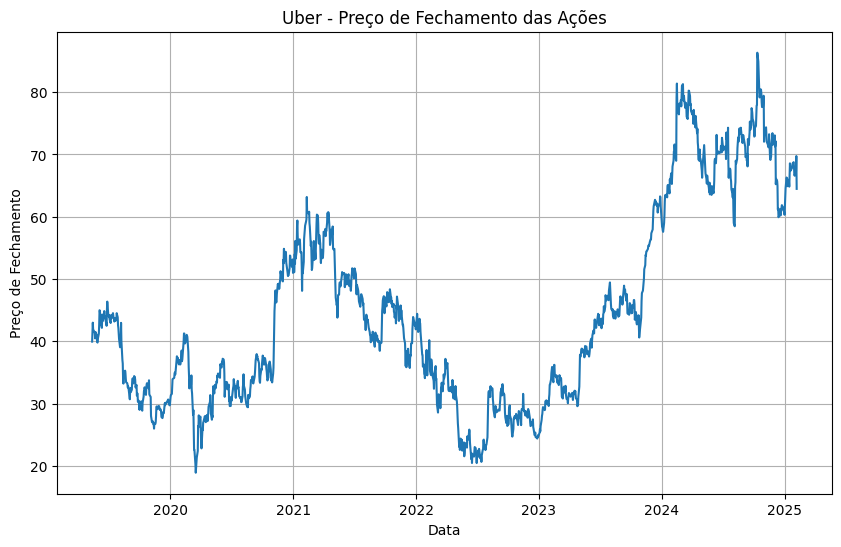

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.plot(stock_data['Close'])
plt.title('Uber - Preço de Fechamento das Ações')
plt.show()

## Testando a estacionariedade dos dados

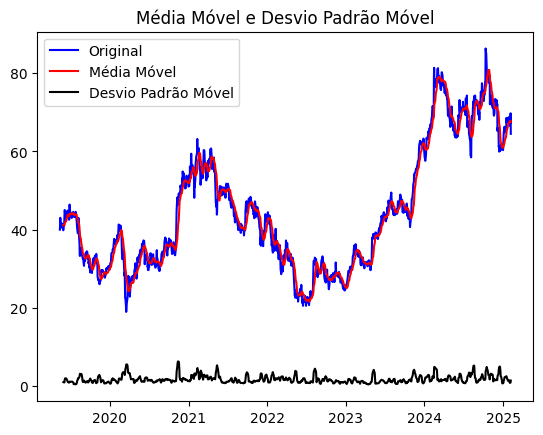

Resultados do Teste Dickey-Fuller:
Test Statistics                  -1.354337
p-value                           0.603961
No. of lags used                  0.000000
Number of observations used    1420.000000
Critical Value (1%)              -3.434963
Critical Value (5%)              -2.863578
Critical Value (10%)             -2.567855
dtype: float64


In [6]:
# Testando a estacionariedade dos dados (se a média e a variância mudam ao longo do tempo)

# Criando uma função para fazer um teste de hipóteses para a estacionariedade dos dados

# Essa função é um teste de hipóteses para verificar se a série é estacionária

def test_stationarity(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Média Móvel')
    plt.plot(rolstd, color='black', label='Desvio Padrão Móvel')
    plt.legend(loc='best')
    plt.title("Média Móvel e Desvio Padrão Móvel")
    plt.show(block=False)
    print("Resultados do Teste Dickey-Fuller:")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key,values in adft[4].items():
        output['Critical Value (%s)'%key] = values
    print(output)

test_stationarity(stock_data['Close'])

<Figure size 640x480 with 0 Axes>

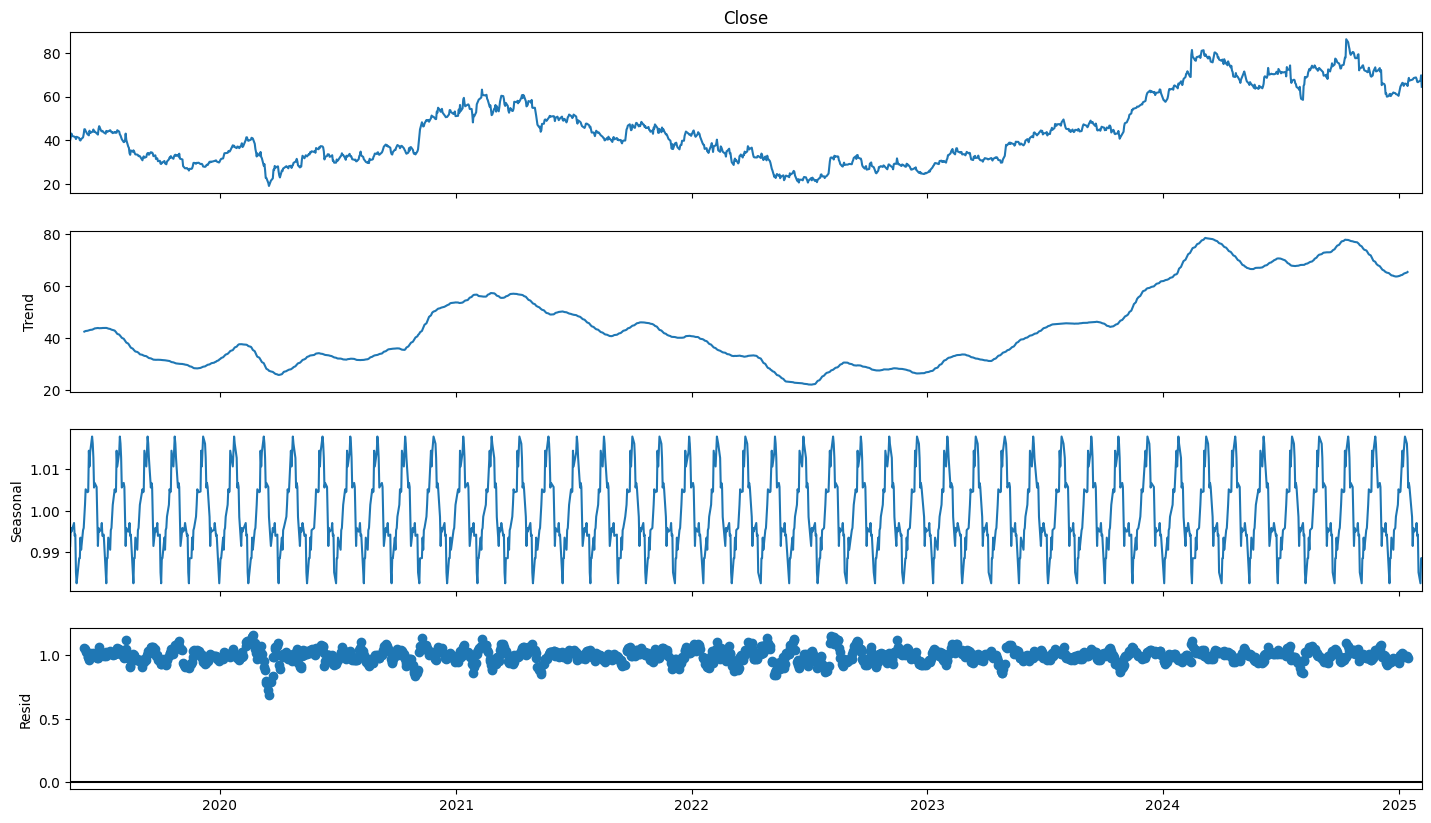

In [7]:
# Como o p-value é superior a 0.05 (para um nível de significância de 5%),
# concluímos que a série não é estacionária.
# Da mesma forma os valores críticos ficaram abaixo das estatísticas do teste.

# Antes de realizar uma análise da série temporal, precisamos analisar a
# Trend: tendência dos dados
# Seasonal: sazonalidade
# Resid: resíduos/ruídos

# Utilizaremos o modelo multiplicativo com período aproximadamente mensal (30 dias)

result = seasonal_decompose(stock_data['Close'], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

## Aplicando a transformação logarítmica dos dados

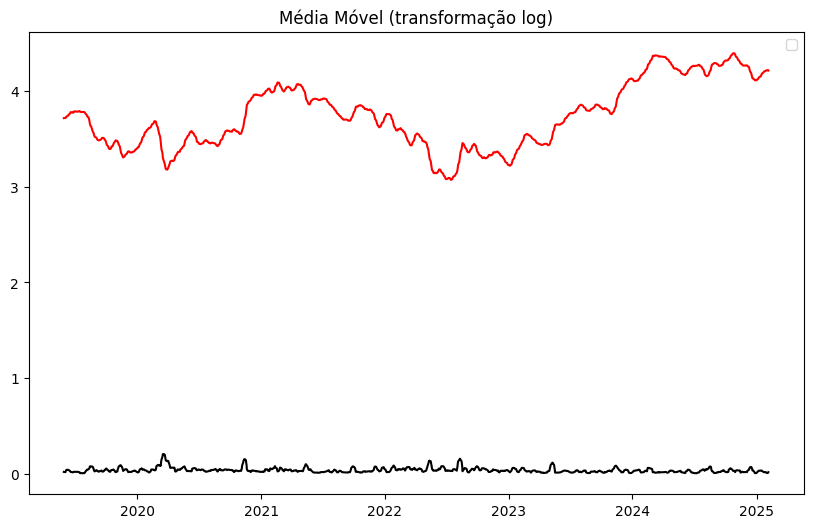

In [8]:
# Com o objetivo de reduzir a magnitude dos valores e a tendência das séries
# iremos fazer uma transformação logarítmica da série.
# Também calcularemos a média móvel da série (após a transformação logarítmica)
# Visamos assim a deixar a série mais estacionária (média e variância mais constantes ao longo do tempo)

rcParams['figure.figsize'] = 10,6
stock_data['Log_Close'] = np.log(stock_data['Close'])
stock_data['Moving_Avg'] = stock_data['Log_Close'].rolling(12).mean()
stock_data['Moving_Std'] = stock_data['Log_Close'].rolling(12).std()
plt.legend(loc='best')
plt.title('Média Móvel (transformação log)')
plt.plot(stock_data['Moving_Avg'], color='red')
plt.plot(stock_data['Moving_Std'], color='black')
plt.legend()
plt.show()


## Separação dos dados de treinamento e teste

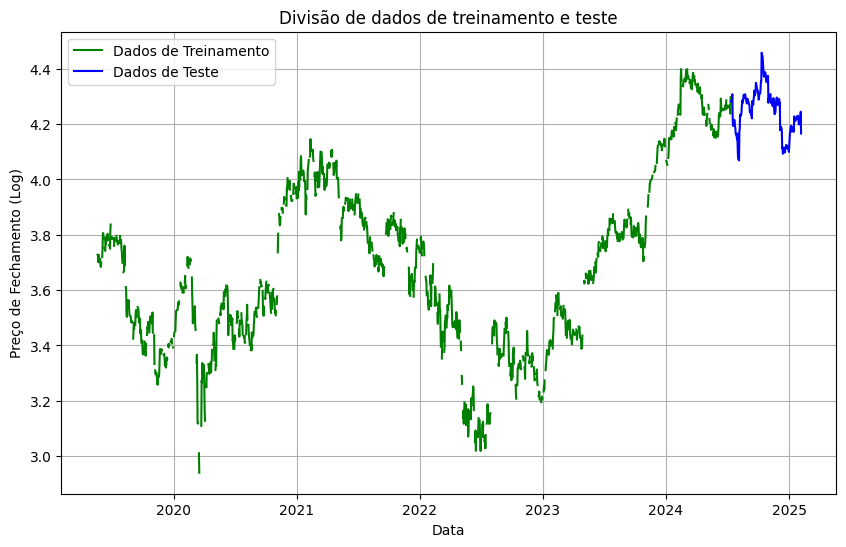

In [9]:
train_data, test_data = stock_data['Log_Close'][3:int(len(stock_data)*0.9)], stock_data['Log_Close'][int(len(stock_data)*0.9):]
# Vamos criar uma cópia dos dados de treinamento sem dados ausentes para usar a função Auto_Arima
train_data_auto = train_data
# A biblioteca Sktime requer que a série train_data tenha frequencia e indice datetime
train_data = train_data.asfreq('D')
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (Log)')
plt.title("Divisão de dados de treinamento e teste")
plt.plot(train_data, 'green', label='Dados de Treinamento')
plt.plot(test_data, 'blue', label='Dados de Teste')
plt.legend()


## Aplicando a função auto_arima para encontrar os coeficientes do modelo

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5137.815, Time=4.57 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5134.422, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5135.843, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5135.440, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5136.182, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5137.633, Time=1.83 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-5136.650, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-5137.216, Time=2.97 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-5136.966, Time=1.65 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5135.657, Time=1.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5137.726, Time=0.92 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-5134.900, Time=3.73 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-5137.876, Time=4.23 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-5138.231, Time=1.78 sec
 ARIMA(4,1,2)(0,0,0

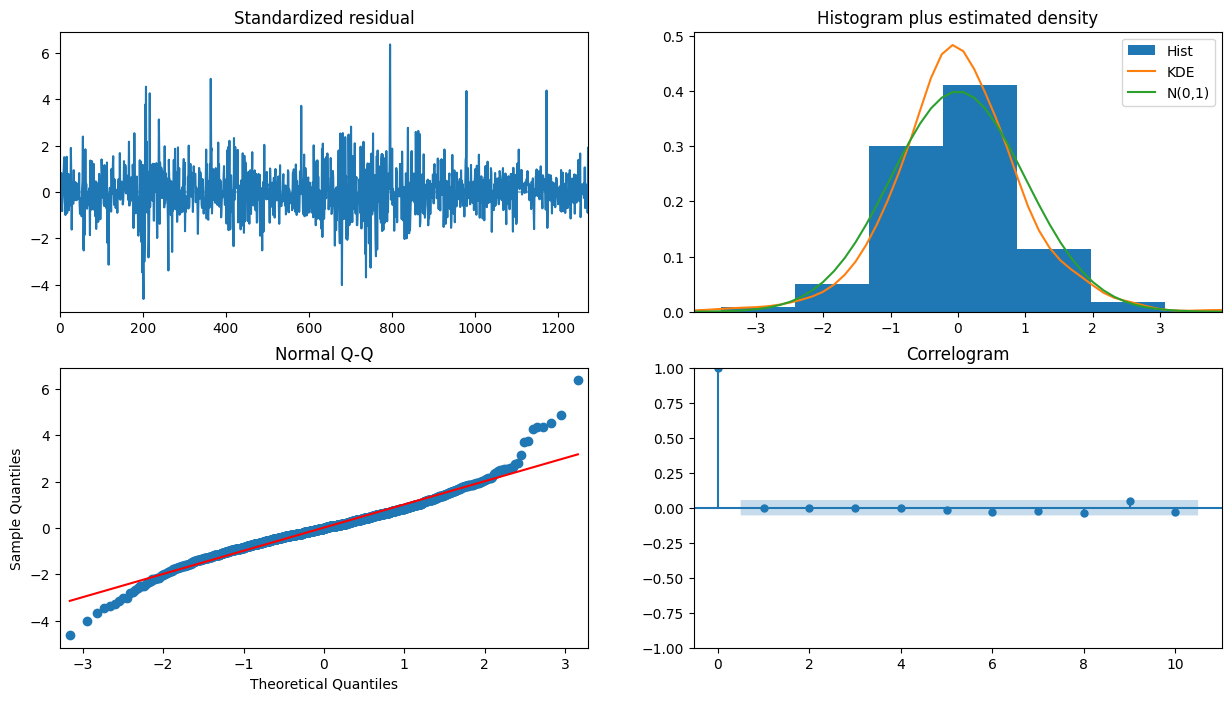

In [10]:
# Utilizando a função auto_arima para calcular os valores p, d e q do modelo
# p: indica número de valores anteriores da série usadas para prever o valor atual
# d: número de diferenciações necessárias para tornar a série estacionária
# q: tamanho da janela da média móvel

model_autoARIMA = auto_arima(train_data_auto,
                             test='adf',
                             m=1,
                             d=None,
                             seasonal=False,
                             trace=True,
                             error_action='ignore',
                             suppress_warnings=True,
                             stepwise=True
                             )

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

## Construindo o modelo e fazendo previsões

In [11]:
# A função auto_arima detectou que os melhores parâmetros para o modelo
# (menor valor de AIC) é o modelo ARIMA(4,1,0)

# Definindo horizonte de previsão (com base no tamanho da série de dados de teste)
fh = ForecastingHorizon(test_data.index, is_relative=False)

# Construindo o modelo

model = ARIMA(order=(4,1,0))
model.fit(train_data)
forecast = model.predict(fh)


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Plotando os dados previstos pelo modelo (escala log)

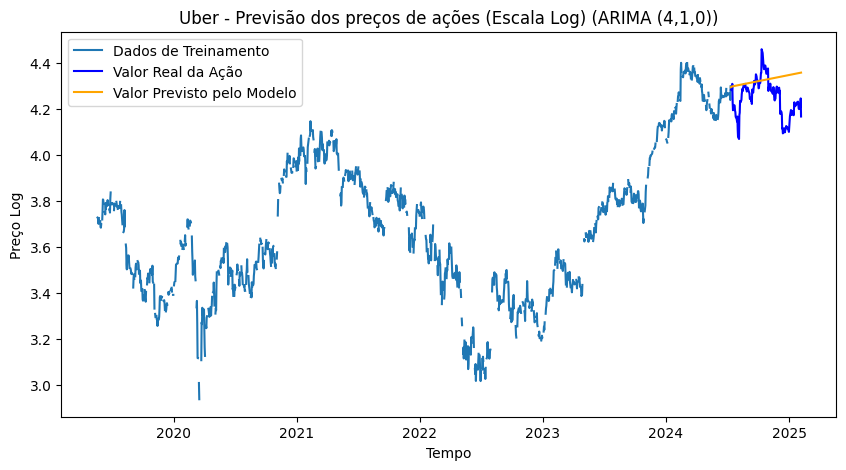

In [12]:
# Faremos um plot com os dados de treinamento, os valores reais
# das ações e adicionalmente, os valores previstos pelo modelo
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Dados de Treinamento')
plt.plot(test_data, label='Valor Real da Ação', color='blue')
plt.plot(forecast, label='Valor Previsto pelo Modelo', color='orange')
plt.title('Uber - Previsão dos preços de ações (Escala Log) (ARIMA (4,1,0))')
plt.xlabel('Tempo')
plt.ylabel('Preço Log')
plt.legend()
plt.show()

## Exponenciando os dados e plotando os dados (escala natural)

In [13]:
# Os dados estão em escala log
# Se quisermos obter os valores reais das ações, precisamos aplicar a exponenciação

train_data_exp = np.exp(train_data)
test_data_exp = np.exp(test_data)
forecast_exp = np.exp(forecast)


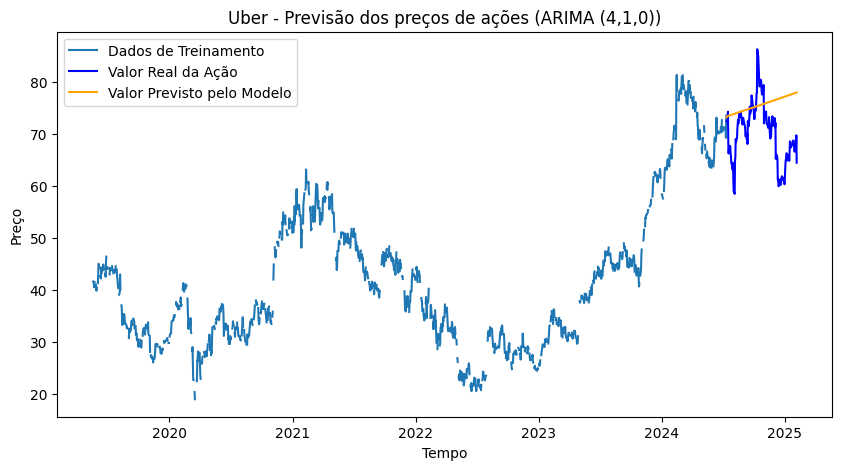

In [14]:
# Plotamos novamente, agora com os valores reais das ações
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data_exp, label='Dados de Treinamento')
plt.plot(test_data_exp, label='Valor Real da Ação', color='blue')
plt.plot(forecast_exp, label='Valor Previsto pelo Modelo', color='orange')
plt.title('Uber - Previsão dos preços de ações (ARIMA (4,1,0))')
plt.xlabel('Tempo')
plt.ylabel('Preço')
plt.legend()
plt.show()

## Exportando os dados previstos pelo modelo

In [15]:
# Obtendo um resumo das métricas dos dados previstos

forecast_exp.describe()

,Log_Close
count,143.000000
mean,75.642970
std,1.333385
min,73.234570
25%,74.502588
50%,75.622138
75%,76.747303
max,78.003186


In [16]:
# Exportando dados previstos pelo modelo para *.csv (após a exponenciação)

forecast_exp.name = 'Close Previsto'
forecast_exp.to_csv('previsao_uber.csv',index=True)